<a href="https://colab.research.google.com/github/nrouyer/cora-graphdatascience/blob/main/Neo4j_Cora_predict_kn_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

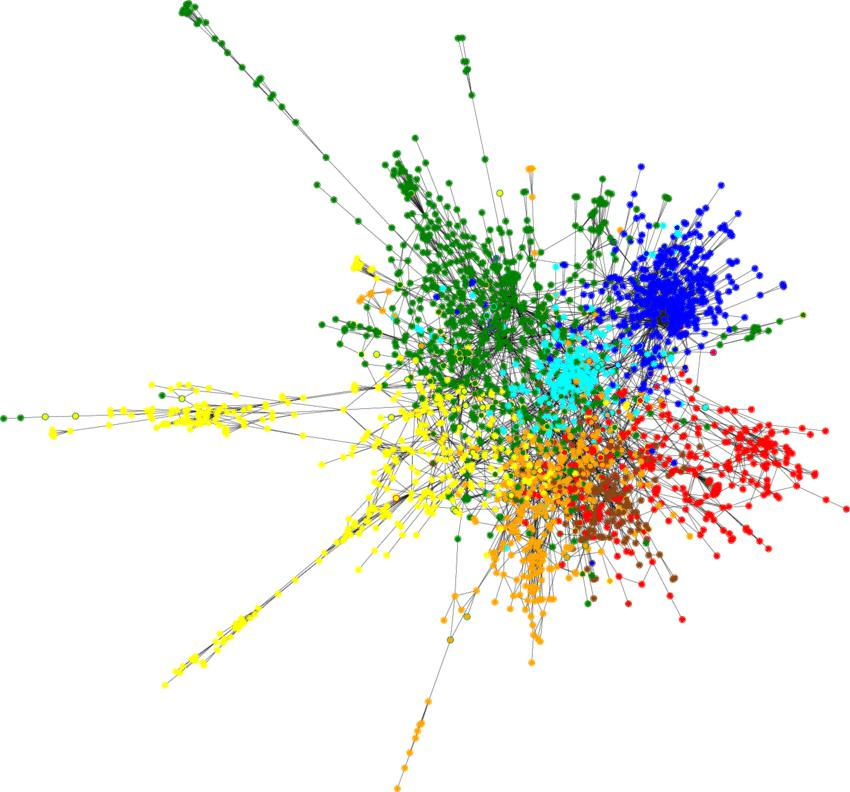

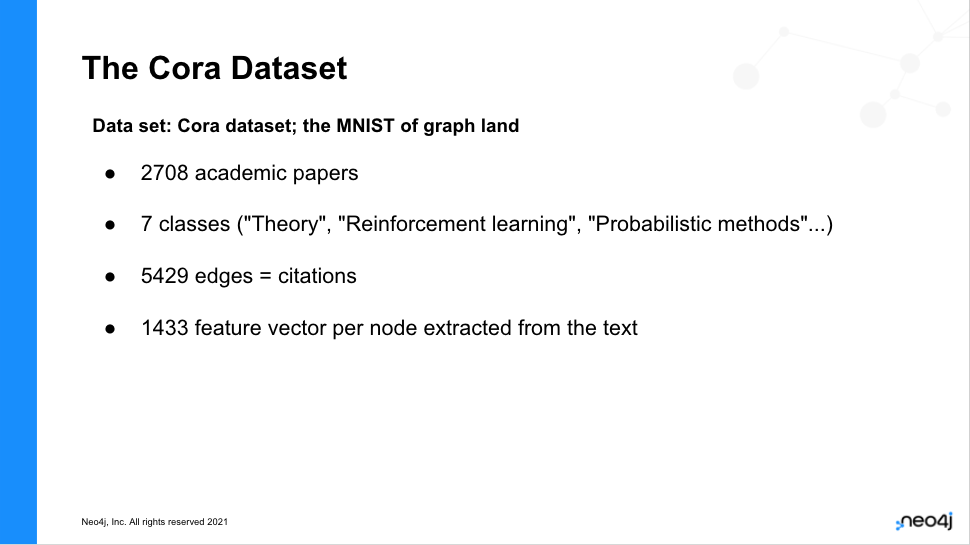

# Spawn your AuraDS instance

You can use a sandbox to play this notebook, but for better performances and response time, you'd rather use an Aura DS instance.

---

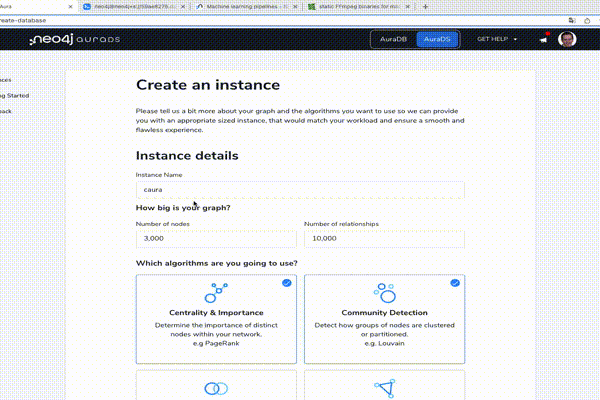


In [ ]:
!pip install graphdatascience

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 517 kB/s 
     |████████████████████████████████| 95 kB 2.7 MB/s 
  Created wheel for neo4j: filename=neo4j-4.4.5-py3-none-any.whl size=123291 sha256=8f788275b8e451bfc8f7d2511f517e6d0985902c1c334462b09a065908a31963
  Stored in directory: /root/.cache/pip/wheels/73/62/2d/6532ffe9b1fdc65f04e7461279cda78fccaa67cf3c706e6e3d
Successfully built neo4j


Getting our credentials - from Sandbox in this example

In [ ]:
!pip install python-dotenv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from dotenv import load_dotenv
import os

load_dotenv("/content/credentials-baeacdce.env")

bolt = os.getenv("NEO4J_URI")
user = os.getenv("NEO4J_USERNAME")
password = os.getenv("NEO4J_PASSWORD")

print(bolt)

neo4j+s://baeacdce.databases.neo4j.io


In [ ]:
auth = (user, password)

Instantiate the new Python GDS Client

In [ ]:
import pandas as pd
from IPython.display import display

from graphdatascience import GraphDataScience

gds = GraphDataScience(bolt, auth=auth, aura_ds=True)

In [ ]:
print(gds.version())


2.1.9


When using Neo4j Sandbox make sure to disable the Timeout:
(DO NOT USE THAT COMMAND WITH AURA)

In [ ]:
node_load_q = """LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/Kristof-Neys/Neo4j-Cora/main/node_list.csv" AS row
WITH toInteger(row.id) AS paperId, row.subject AS subject, row.features AS features
MERGE (p:Paper {paper_Id: paperId})
SET p.subject = subject, p.features = apoc.convert.fromJsonList(features)
RETURN count(p)
"""


edge_load_q = """
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/Kristof-Neys/Neo4j-Cora/main/edge_list.csv" AS row
MATCH(source: Paper {paper_Id: toInteger(row.source)})
MATCH(target: Paper {paper_Id: toInteger(row.target)})
MERGE (source)-[r:CITES]->(target)
"""

In [ ]:
gds.run_cypher(node_load_q)

count(p)
0      2708

In [ ]:
gds.run_cypher(edge_load_q)

Empty DataFrame
Columns: []
Index: []



---

Let us visualize the CORA graph in Bloom: 
(Paper that CITES Paper)

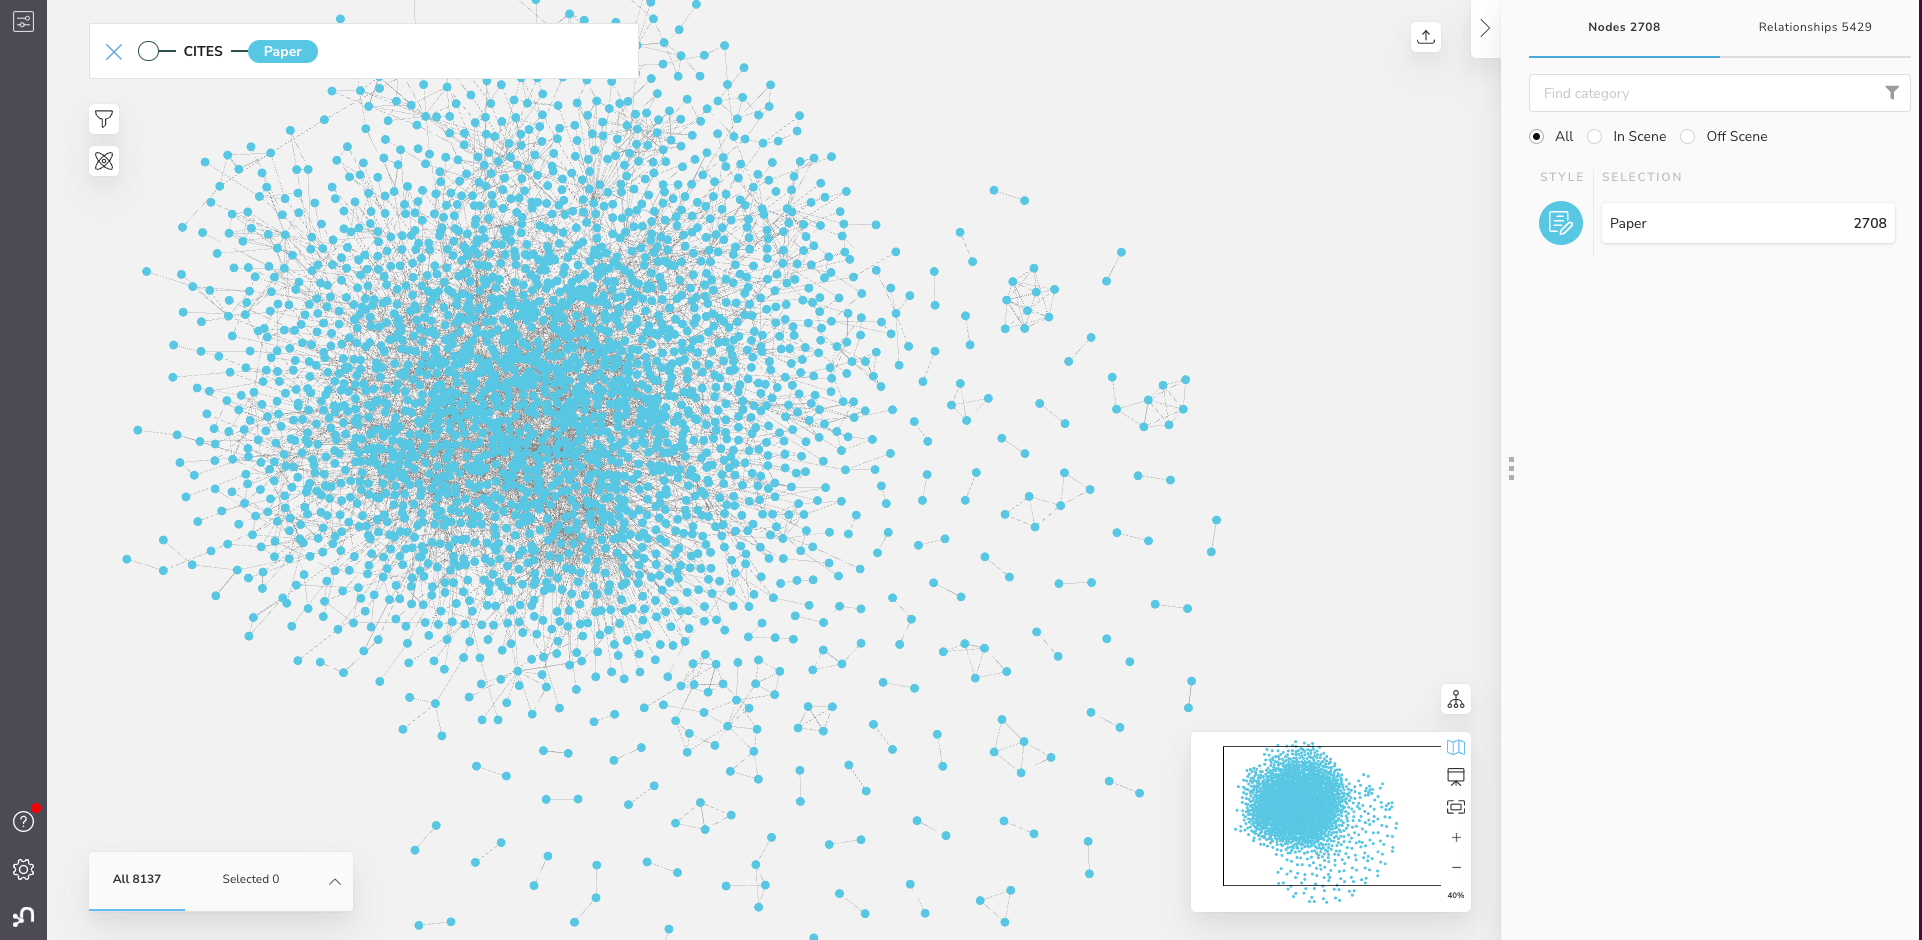

# Quick peak at the features in the database

In [ ]:
q_peak = """MATCH (n) WHERE EXISTS(n.features) RETURN DISTINCT n.paper_Id as PaperId, n.subject  AS Paper_Subject, n.features AS features LIMIT 5"""
res = gds.run_cypher(q_peak)
df = pd.DataFrame.from_dict(res)
display(df.head(5))

PaperId           Paper_Subject  \
0    31336         Neural_Networks   
1  1061127           Rule_Learning   
2  1106406  Reinforcement_Learning   
3    13195  Reinforcement_Learning   
4    37879   Probabilistic_Methods   

                                            features  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

Convert Subjects to numerical

In [ ]:
query_Subj = """MATCH (p:Paper)
WITH collect(DISTINCT p.subject) as listSubjects
WITH  listSubjects, size(listSubjects) AS sizeListSubjects
WITH listSubjects, range(1, sizeListSubjects) AS rangeSubjects
WITH apoc.map.fromLists(listSubjects, rangeSubjects) AS mapSubjects
MATCH (p:Paper)
SET p.subjectClass = mapSubjects[p.subject];""" 

gds.run_cypher(query_Subj)

Empty DataFrame
Columns: []
Index: []

TODO : perform jaccard similarity between Paper nodes with the features property (collection)

# Time to start the GDS Engines
We will be doing two different projections:

1.   Projection to run Fast RP on
2.   Projection with the embeddings included


TODO : defaultValue As a parameter (list comprehension)

In [ ]:
G, res = gds.graph.project(
    "cora-graph", 
    {"Paper": {"properties": ["subjectClass", "features"]} },
    {"CITES": {"orientation": "UNDIRECTED", "aggregation": "SINGLE"}}
)

Loading:   0%|          | 0/100 [00:00<?, ?%/s]

In [ ]:
# A few information on the projected graph:
print(G.name())             # cora-graph
print(G.memory_usage())     # 30 MiB
print(G.density())          # 0.0014399999126942077

cora-graph
30 MiB
0.0014399999126942077


# The GDS client allows to determine the Graph as an object with a bunch of methods developed for it


In [ ]:

print("Properties of the nodes are: ", G.node_properties('Paper'), ", total number of nodes is: ", G.node_count(), ", and size of the graph is ",  G.size_in_bytes())

Properties of the nodes are:  ['features', 'subjectClass'] , total number of nodes is:  2708 , and size of the graph is  31960399


# FastRP Time!

In [ ]:
# pythonic way to fastRP :
fastrp_res = gds.fastRP.write(
    G,                                #  Graph object
    featureProperties=["features"],   #  Configuration parameters
    embeddingDimension=128,
    iterationWeights=[0, 0, 1.0, 1.0],
    normalizationStrength=0.05,
    writeProperty="fastRP_Extended_Embedding"
)

In [ ]:
# pythonic way to fastRP in mutate mode :
fastrp_res = gds.fastRP.mutate(
    G,                                #  Graph object
    featureProperties=["features"],   #  Configuration parameters
    embeddingDimension=128,
    iterationWeights=[0, 0, 1.0, 1.0],
    normalizationStrength=0.05,
    mutateProperty="fastRP_Extended_Embedding"
)

In [ ]:
assert fastrp_res["nodePropertiesWritten"] == G.node_count()

In [ ]:
print(fastrp_res)

nodePropertiesWritten                                                 2708
mutateMillis                                                             1
nodeCount                                                             2708
preProcessingMillis                                                      1
computeMillis                                                           83
configuration            {'nodeSelfInfluence': 0, 'relationshipWeightPr...
Name: 0, dtype: object


TODO : have a look at the iteration weights

## Perform TSNE on the embeddings

In [ ]:
G.node_properties('Paper') 
# ['features', 'subjectClass'] if using write mode for fastRP 
# ['features', 'fastRP_Extended_Embedding', 'subjectClass'] if using mutate mode

['features', 'fastRP_Extended_Embedding', 'subjectClass']

In [ ]:
from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns
import pandas as pd


embedding_df = gds.graph.streamNodeProperty(G, 'fastRP_Extended_Embedding')
subject_df = gds.graph.streamNodeProperty(G, 'subjectClass')

# regroup in a single dataframe embedding and subjectClass
df = pd.DataFrame({'x':embedding_df["propertyValue"], 'y':subject_df["propertyValue"]})
df.head()


x  y
0  [0.10592278093099594, -0.09589221328496933, -0...  1
1  [-0.03795634210109711, 0.20917123556137085, -0...  2
2  [-0.036252859979867935, 0.15076635777950287, -...  3
3  [-0.0428265705704689, 0.313854455947876, -0.01...  3
4  [-0.1682453453540802, 0.006559010595083237, -0...  4

In [ ]:
embedding_df.head()

nodeId                                      propertyValue
0       0  [0.10592278093099594, -0.09589221328496933, -0...
1       1  [-0.03795634210109711, 0.20917123556137085, -0...
2       2  [-0.036252859979867935, 0.15076635777950287, -...
3       3  [-0.0428265705704689, 0.313854455947876, -0.01...
4       4  [-0.1682453453540802, 0.006559010595083237, -0...

In [ ]:
X_embedded = TSNE(n_components=2, random_state=6).fit_transform(list(df.x))

subjects = df.y
tsne_df = pd.DataFrame(data = {
    "subject": subjects,
    "x": [value[0] for value in X_embedded],
    "y": [value[1] for value in X_embedded]
})
tsne_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


subject          x          y
0        1 -21.552055 -54.230129
1        2  -1.943362  17.176506
2        3 -16.237738  50.154957
3        3 -12.293010  54.172035
4        4  24.619366  11.047729

In [ ]:
!pip install altair

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import altair as alt

alt.Chart(tsne_df).mark_circle(size=60).encode(
    x='x',
    y='y',
    color='subject',
    tooltip=['subject']
).properties(width=700, height=400)

alt.Chart(...)

Seems like Paper nodes with same subjects are not that far from each other...
Let's confirm this intuition given by T-SNE.

# Let's have a look at those Embedding vectors

In [ ]:
q_embed = ("""MATCH (n) WHERE EXISTS(n.fastRP_Extended_Embedding) RETURN DISTINCT "node" as entity, n.fastRP_Extended_Embedding AS fastRP_Extended_Embedding LIMIT 2 """)

query_Embed = gds.run_cypher(q_embed)
df_Embed = pd.DataFrame.from_dict(query_Embed)
display(df_Embed)

Empty DataFrame
Columns: [entity, fastRP_Extended_Embedding]
Index: []

## Embeddings shown in Bloom

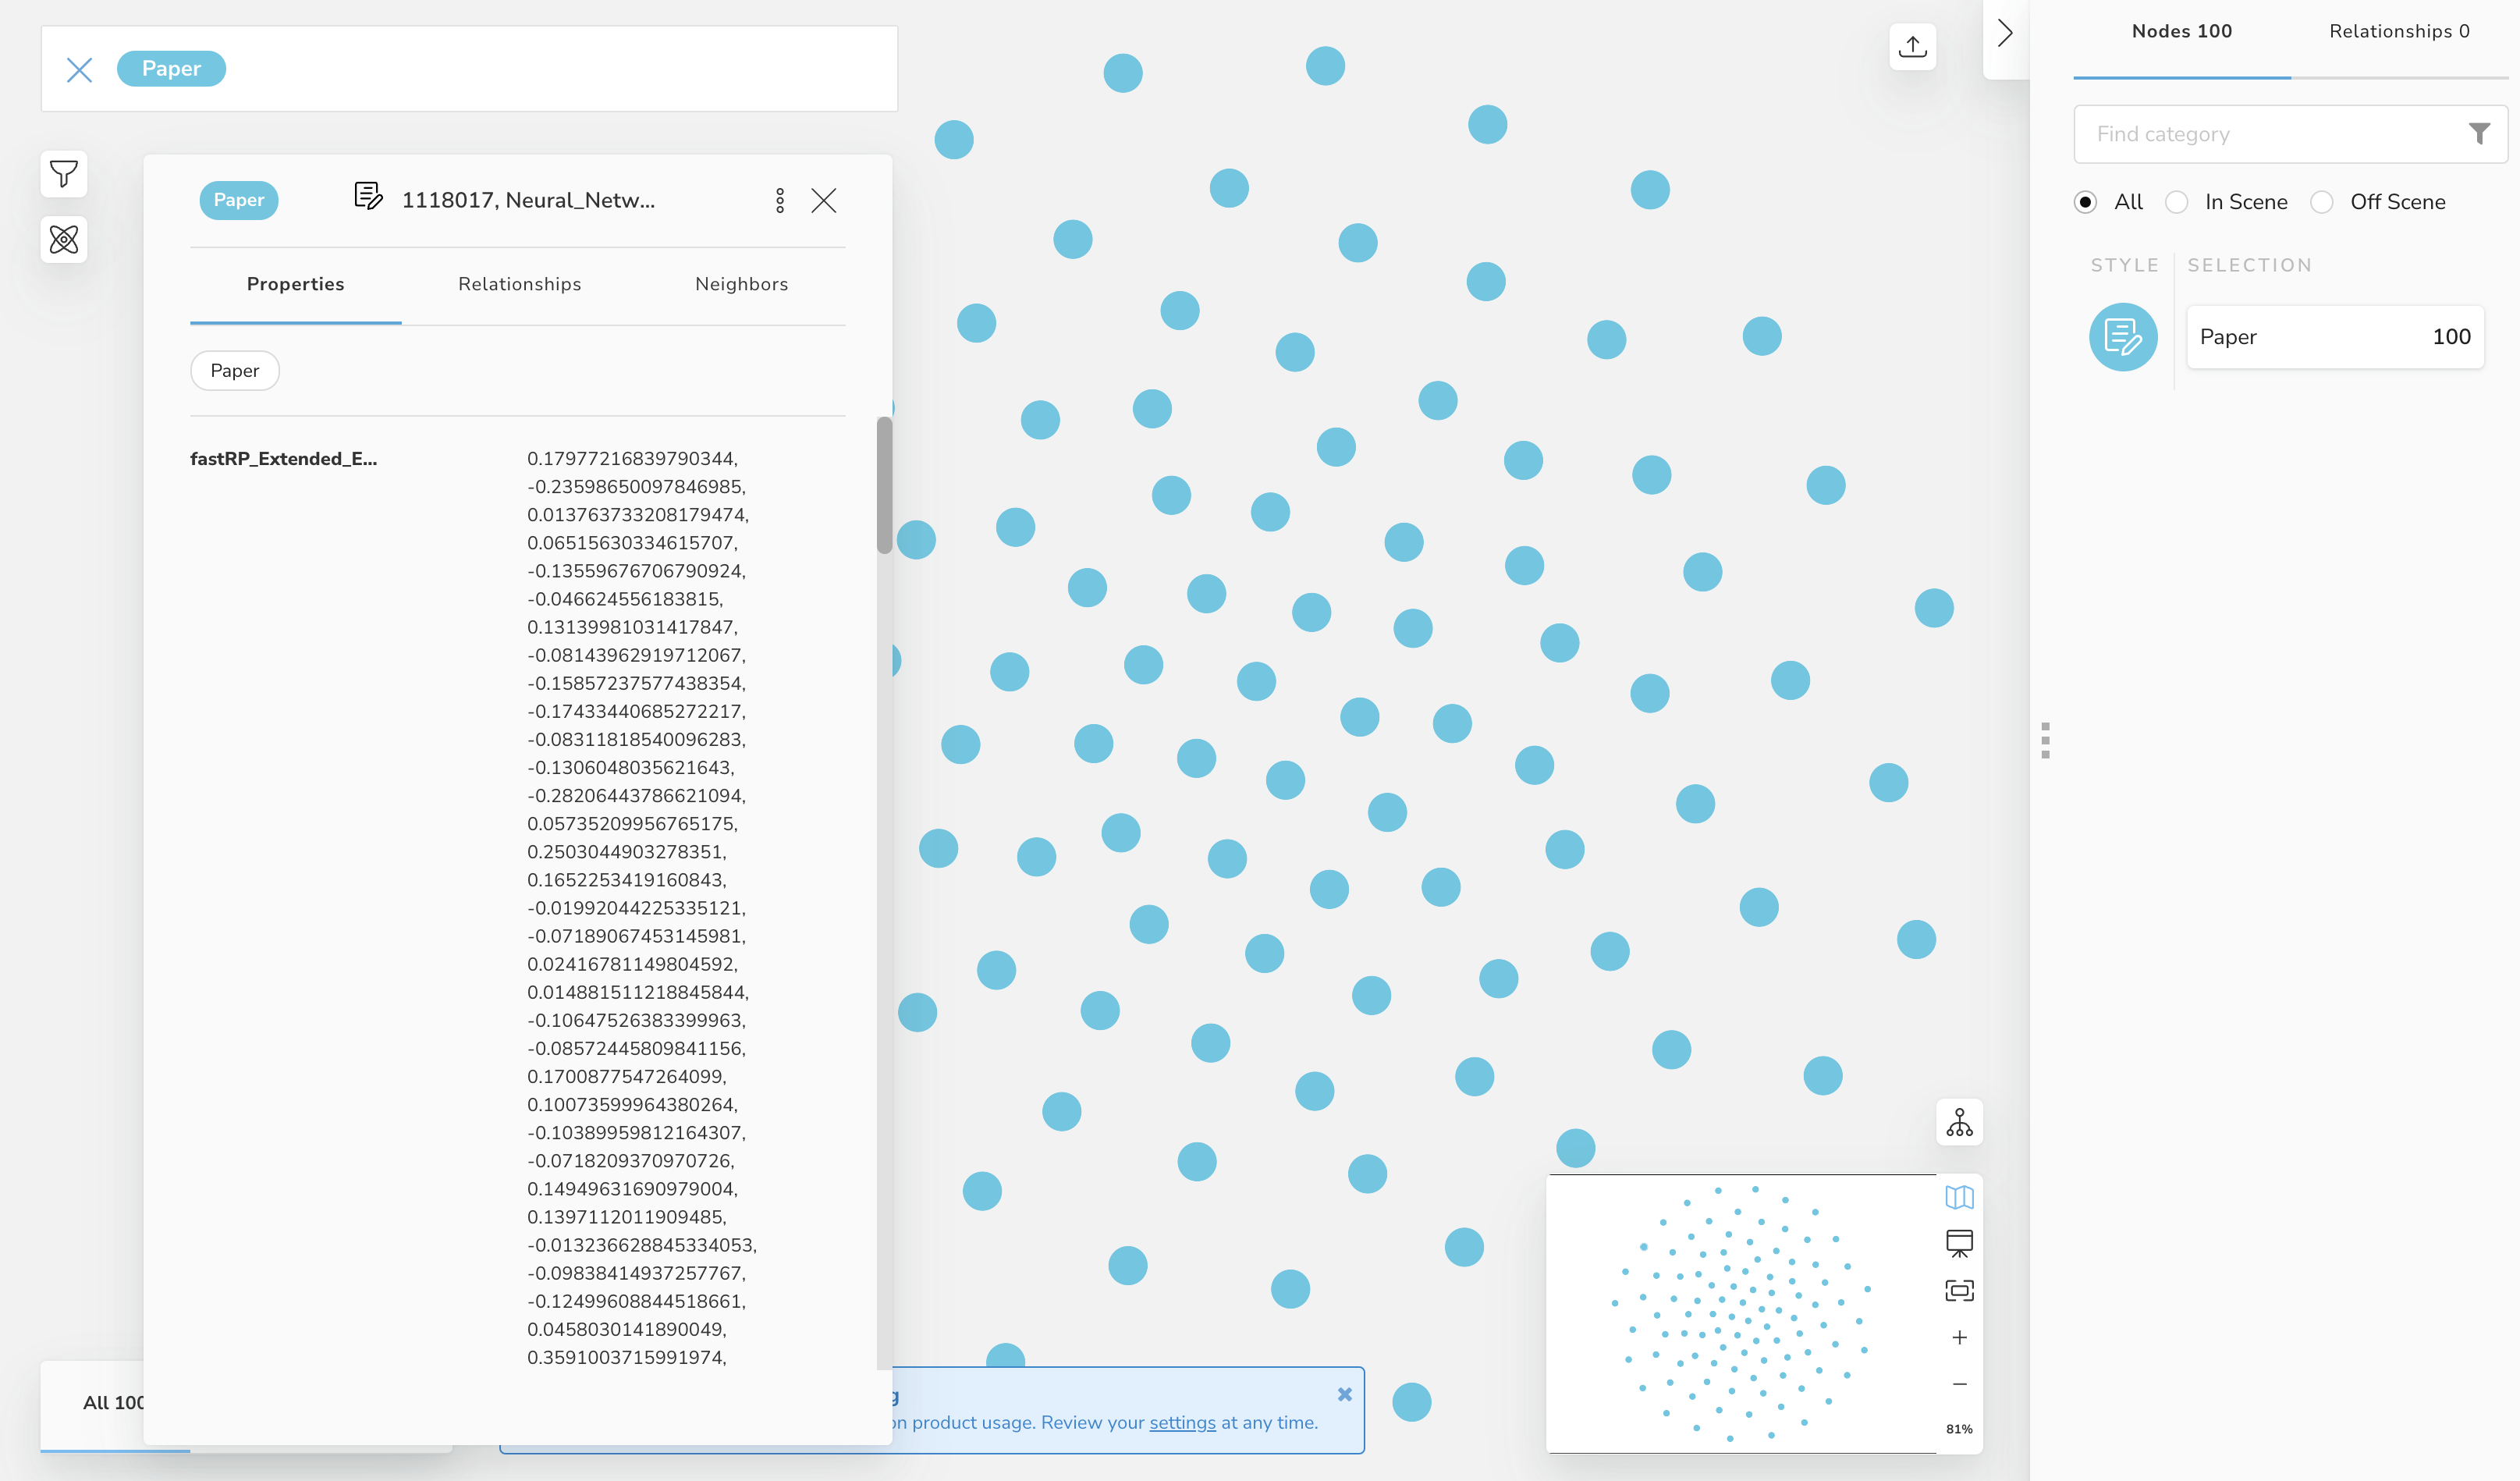



# Node Classification ML Pipeline using "features" property

We will slice of 20% of the graph as test graph and make predictions on, so as to check the accuracy of the model on unseen data

In [ ]:
pipe, _ = gds.beta.pipeline.nodeClassification.create("cora-pipe")

Print pipeline splitConfig

In [ ]:
pipe.split_config()

testFraction       0.3
validationFolds    3.0
dtype: float64

Print pipeline autotuning configuration

In [ ]:
pipe.auto_tuning_config()

maxTrials    10
dtype: int64

Change split configuration

In [ ]:
pipe.configureSplit(testFraction=0.2, validationFolds=5)

name                                                      cora-pipe
nodePropertySteps                                                []
featureProperties                                                []
splitConfig             {'testFraction': 0.2, 'validationFolds': 5}
autoTuningConfig                                  {'maxTrials': 10}
parameterSpace       {'RandomForest': [], 'LogisticRegression': []}
Name: 0, dtype: object

Select features (without embeddings for the moment)

In [ ]:
pipe.selectFeatures(['features'])

name                                                      cora-pipe
nodePropertySteps                                                []
featureProperties                                        [features]
splitConfig             {'testFraction': 0.2, 'validationFolds': 5}
autoTuningConfig                                  {'maxTrials': 10}
parameterSpace       {'RandomForest': [], 'LogisticRegression': []}
Name: 0, dtype: object

Adding available models in the pipeline

In [ ]:
pipe.addLogisticRegression(tolerance=0.001, maxEpochs=100, penalty=0.0, batchSize=32)
pipe.addRandomForest(maxDepth=(20))

name                                                         cora-pipe
nodePropertySteps                                                   []
featureProperties                                           [features]
splitConfig                {'testFraction': 0.2, 'validationFolds': 5}
autoTuningConfig                                     {'maxTrials': 10}
parameterSpace       {'RandomForest': [{'maxDepth': 20, 'minLeafSiz...
Name: 0, dtype: object

Showing pipeline parameter space

In [ ]:
pipe.parameter_space()

RandomForest          [{'maxDepth': 20, 'minLeafSize': 1, 'criterion...
LogisticRegression    [{'maxEpochs': 100, 'minEpochs': 1, 'penalty':...
dtype: object

Training the pipeline

In [ ]:
trained_pipe_model, res = pipe.train(G, modelName="cora-features-model", targetProperty="subjectClass", metrics=["ACCURACY", "F1_WEIGHTED"])
assert res["trainMillis"] >= 0

Node Classification Train Pipeline:   0%|          | 0/100 [00:00<?, ?%/s]

Showing the metrics for the model

In [ ]:
trained_pipe_model.metrics()

F1_WEIGHTED    {'test': 0.6384318122087168, 'outerTrain': 0.8...
ACCURACY       {'test': 0.65867159, 'outerTrain': 0.85041552,...
dtype: object

Now, let us predict!

In [ ]:
result = trained_pipe_model.predict_write(G, concurrency=8, writeProperty="featuresPredictedClass", predictedProbabilityProperty="featuresPredictedProbability")


Looking at the result:

In [ ]:
result

nodePropertiesWritten                                                 5416
writeMillis                                                             81
postProcessingMillis                                                     0
preProcessingMillis                                                      0
computeMillis                                                          124
configuration            {'graphName': 'cora-graph', 'jobId': '9903cdc4...
Name: 0, dtype: object

Check accuracy of the model

In [ ]:
query_check = """MATCH (p:Paper)
WHERE p.featuresPredictedClass IS NOT NULL
WITH count(p) AS nbPapers
MATCH (p:Paper)
WHERE p.featuresPredictedClass IS NOT NULL
AND p.featuresPredictedClass = p.subjectClass
RETURN toFloat(count(p)) / nbPapers AS ratio"""

q_check = gds.run_cypher(query_check)

df_q_check = pd.DataFrame.from_dict(q_check)

# print(q_check)
display(df_q_check)

ratio
0  0.825332

# New pipeline with embedding as a feature

Let us rebuild a new pipeline, this time with embeddings

In [ ]:
pipe_embedding, _ = gds.beta.pipeline.nodeClassification.create("cora-embedding-pipe")

Print pipeline splitConfig

In [ ]:
pipe_embedding.split_config()

testFraction       0.3
validationFolds    3.0
dtype: float64

Print pipeline autotuning configuration

In [ ]:
pipe_embedding.auto_tuning_config()

maxTrials    10
dtype: int64

Change split configuration

In [ ]:
pipe_embedding.configureSplit(testFraction=0.2, validationFolds=5)

name                                            cora-embedding-pipe
nodePropertySteps                                                []
featureProperties                                                []
splitConfig             {'testFraction': 0.2, 'validationFolds': 5}
autoTuningConfig                                  {'maxTrials': 10}
parameterSpace       {'RandomForest': [], 'LogisticRegression': []}
Name: 0, dtype: object

Select features (this time, with embeddings)

In [ ]:
pipe_embedding.selectFeatures(['features', 'fastRP_Extended_Embedding'])

name                                            cora-embedding-pipe
nodePropertySteps                                                []
featureProperties             [features, fastRP_Extended_Embedding]
splitConfig             {'testFraction': 0.2, 'validationFolds': 5}
autoTuningConfig                                  {'maxTrials': 10}
parameterSpace       {'RandomForest': [], 'LogisticRegression': []}
Name: 0, dtype: object

Adding available models in the pipeline

In [ ]:
pipe_embedding.addLogisticRegression(tolerance=0.001, maxEpochs=100, penalty=0.0, batchSize=32)
pipe_embedding.addRandomForest(maxDepth=(20))

name                                               cora-embedding-pipe
nodePropertySteps                                                   []
featureProperties                [features, fastRP_Extended_Embedding]
splitConfig                {'testFraction': 0.2, 'validationFolds': 5}
autoTuningConfig                                     {'maxTrials': 10}
parameterSpace       {'RandomForest': [{'maxDepth': 20, 'minLeafSiz...
Name: 0, dtype: object

Showing pipeline parameter space

In [ ]:
pipe_embedding.parameter_space()

RandomForest          [{'maxDepth': 20, 'minLeafSize': 1, 'criterion...
LogisticRegression    [{'maxEpochs': 100, 'minEpochs': 1, 'penalty':...
dtype: object

Training the pipeline

In [ ]:
trained_pipe_embedding_model, res = pipe_embedding.train(G, modelName="cora-features-embedding-model", targetProperty="subjectClass", metrics=["ACCURACY", "F1_WEIGHTED"])
assert res["trainMillis"] >= 0

Node Classification Train Pipeline:   0%|          | 0/100 [00:00<?, ?%/s]

Showing the metrics for the model

In [ ]:
trained_pipe_embedding_model.metrics()

F1_WEIGHTED    {'test': 0.773254833315127, 'outerTrain': 0.90...
ACCURACY       {'test': 0.77675277, 'outerTrain': 0.90904894,...
dtype: object

We can see that test metrics are better with embeddings

Now, let us predict!

In [ ]:
result = trained_pipe_embedding_model.predict_write(G, concurrency=8, writeProperty="featuresEmbeddingPredictedClass", predictedProbabilityProperty="featuresEmbeddingPredictedProbability")


Looking at the result:

In [ ]:
result

nodePropertiesWritten                                                 5416
writeMillis                                                             58
postProcessingMillis                                                     0
preProcessingMillis                                                      0
computeMillis                                                           19
configuration            {'graphName': 'cora-graph', 'jobId': '993e65b8...
Name: 0, dtype: object

Check accuracy of the model

In [ ]:
query_check = """MATCH (p:Paper)
WHERE p.featuresEmbeddingPredictedClass IS NOT NULL
WITH count(p) AS nbPapers
MATCH (p:Paper)
WHERE p.featuresEmbeddingPredictedClass IS NOT NULL
AND p.featuresEmbeddingPredictedClass = p.subjectClass
RETURN toFloat(count(p)) / nbPapers AS ratio"""

q_check = gds.run_cypher(query_check)

df_q_check = pd.DataFrame.from_dict(q_check)

# print(q_check)
display(df_q_check)

ratio
0  0.89808

Yoohoo! Ratio is now 89%!
Let us show it in Bloom:

In [ ]:
query_update_1 = """MATCH (p:Paper)
WHERE p.featuresPredictedClass IS NOT NULL
AND p.featuresPredictedClass = p.subjectClass
SET p.trueFeaturesPrediction = true"""

q_check = gds.run_cypher(query_update_1)

In [ ]:
query_update_2 = """MATCH (p:Paper)
WHERE p.featuresEmbeddingPredictedClass IS NOT NULL
AND p.featuresEmbeddingPredictedClass = p.subjectClass
SET p.trueFeaturesEmbeddingPrediction = true"""

q_check = gds.run_cypher(query_update_2)

Then we can display 100 Paper nodes, and apply a rule-based policy to display predicted subject that are accurate in dark blue:

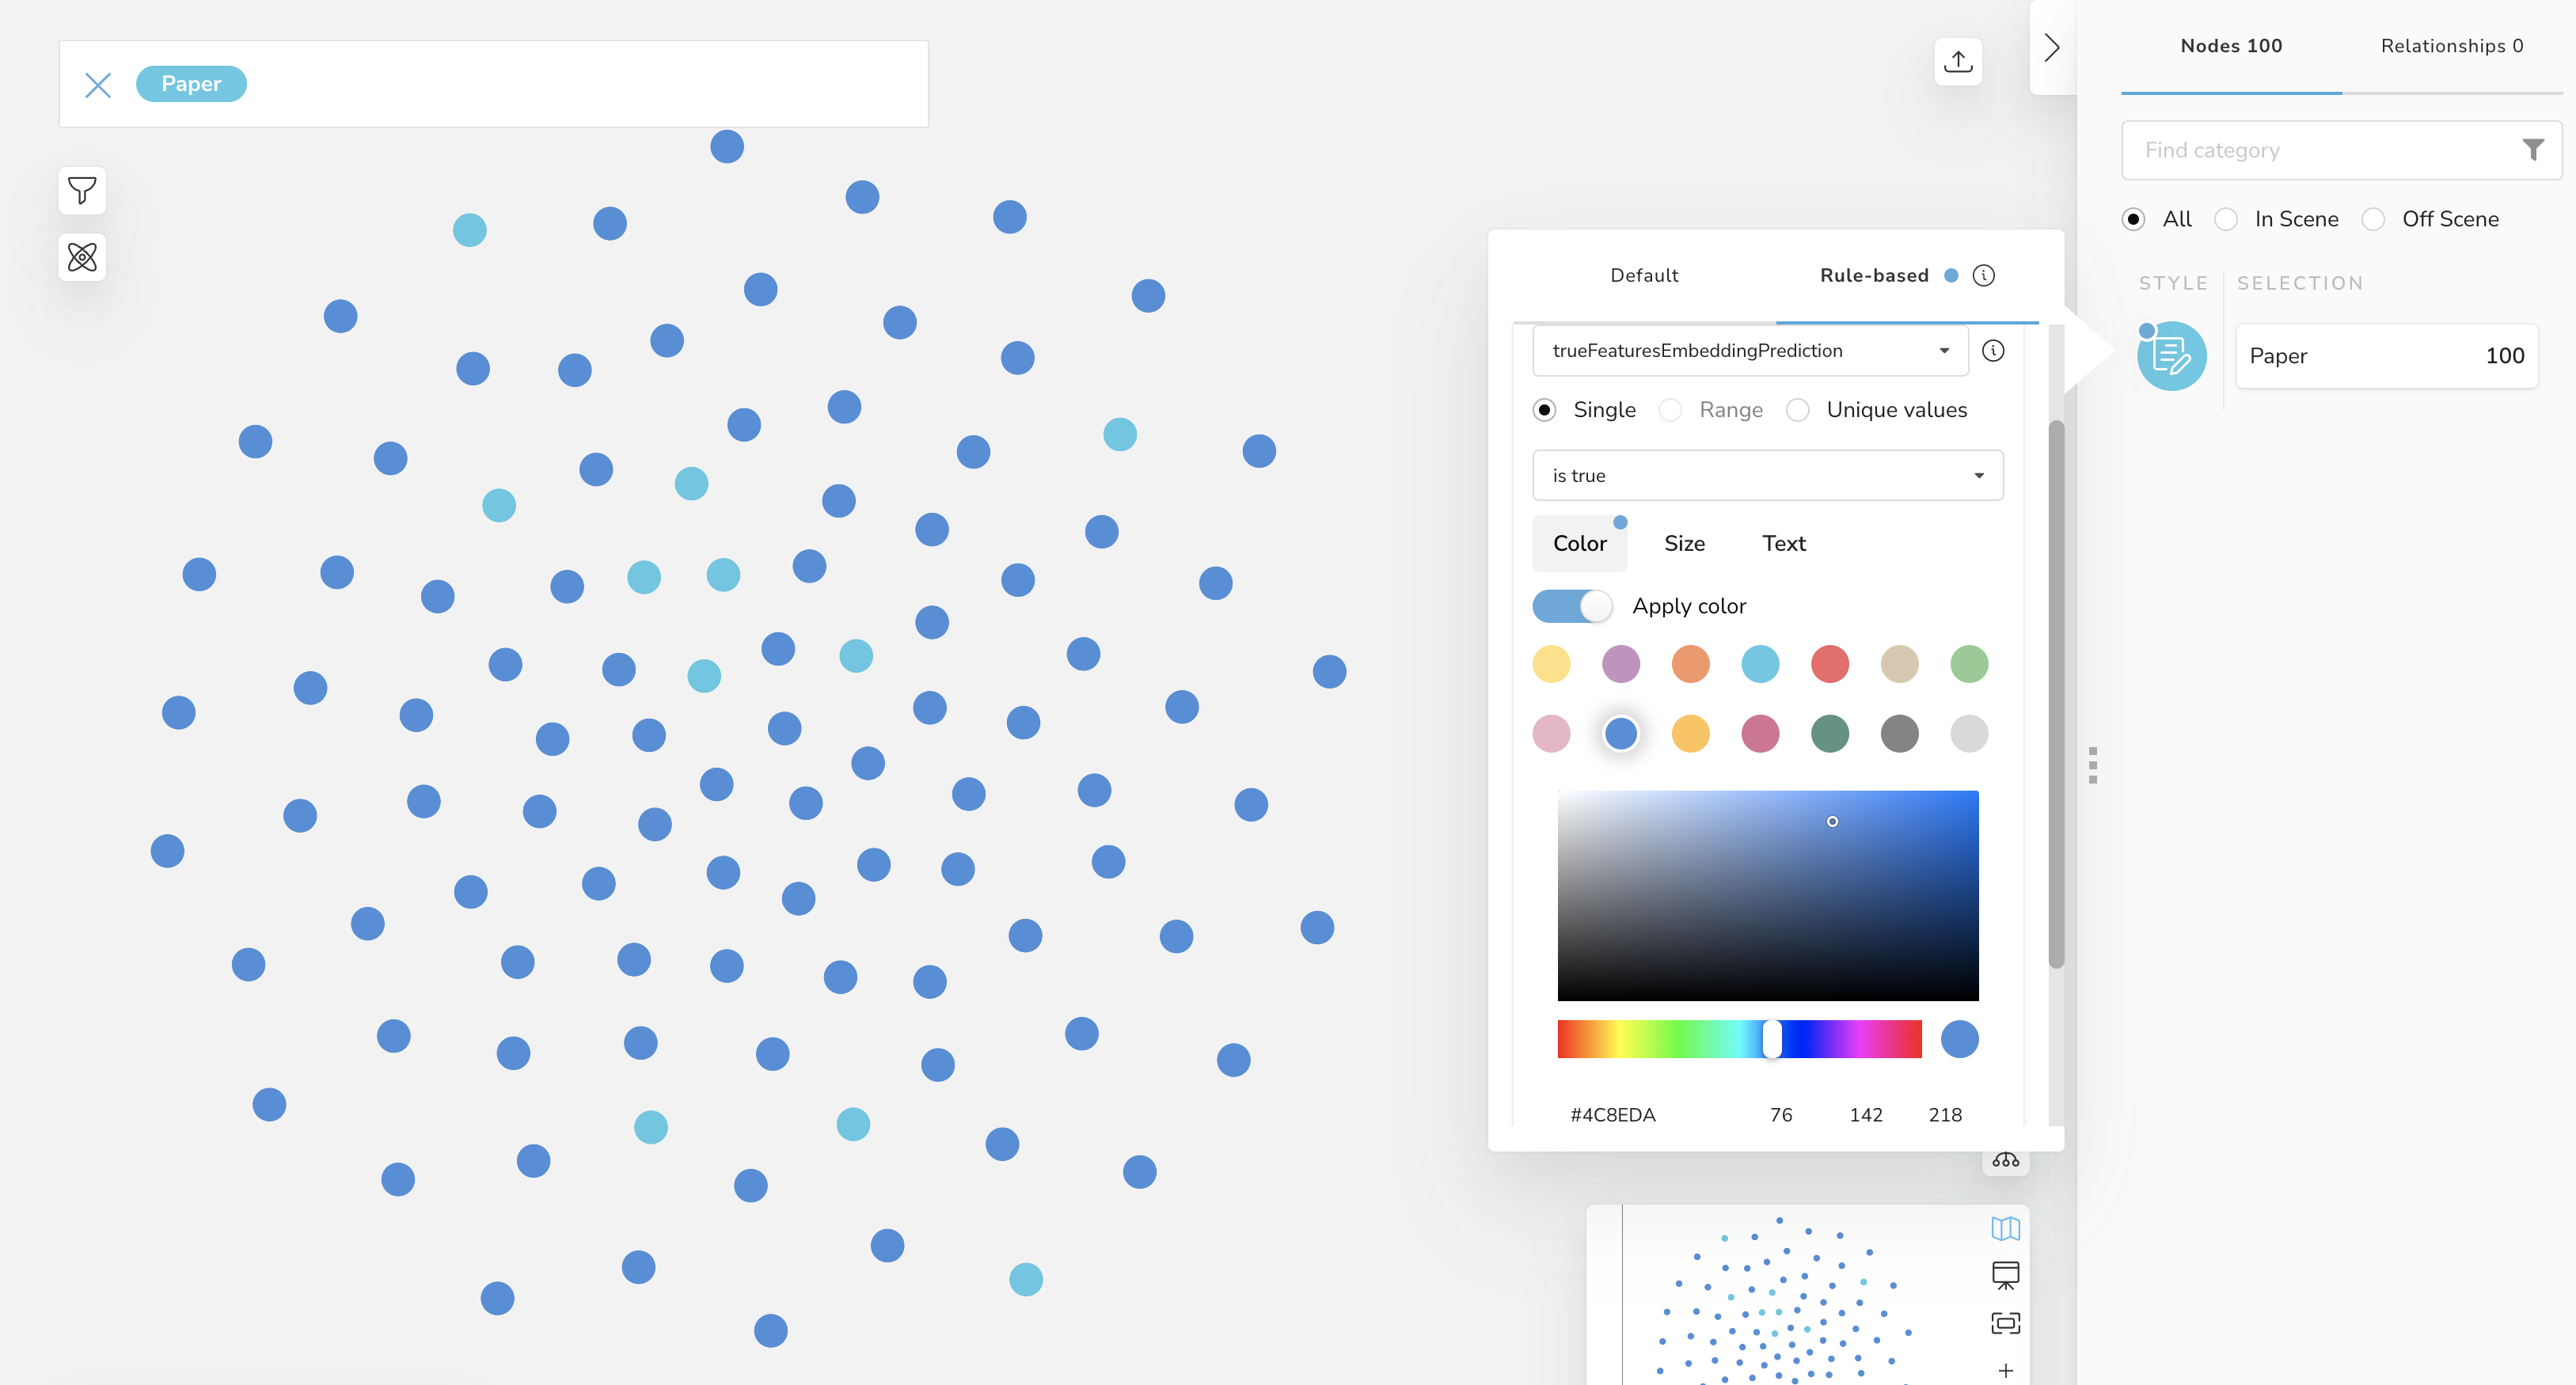

We can easily count the number of Paper nodes for which subject was badly predicted: there are 11 of them
=> our 89% accuracy is here 🤓

# TODO: New pipeline with embedding + other computed graph properties as features

# **Some fancy stuff**

In [ ]:
model_list = gds.run_cypher(""" CALL gds.beta.model.list()""")
df_model_list = pd.DataFrame.from_dict(model_list)

display(df_model_list)

modelInfo  \
0  {'modelName': 'Cora_model_FRP', 'classes': [1,...   

                                         trainConfig  \
0  {'holdoutFraction': 0.2, 'params': [{'maxEpoch...   

                                         graphSchema  loaded  stored  \
0  {'relationships': {'CITES': {}}, 'nodes': {'Pa...    True   False   

                          creationTime  shared  
0  2022-03-22T10:11:08.834783000+00:00   False

In [ ]:
model_name = 'Cora_model_FRP'

for model in model_list:
    if model['modelInfo']['modelName'] == model_name:
        print("====================================")
        print(f"Stats for {model_name}")
        print("------------------------------------")
        bestParams = model['modelInfo']['bestParameters']
        metrics = model['modelInfo']['metrics'].keys()
        for m in metrics:
            outerTrain = model['modelInfo']['metrics'][m]['outerTrain']
            test = model['modelInfo']['metrics'][m]['test']
            print(f"For metric : {m} \n train graph score : {outerTrain}\n test graph score : {test}")
            print("--------------------------------")
        print(f"Best Parameters : \n {bestParams}")
        print("====================================")

Stats for Cora_model_FRP
------------------------------------
For metric : F1_WEIGHTED 
 train graph score : 0.7262754345313276
 test graph score : 0.6773512803324692
--------------------------------
For metric : ACCURACY 
 train graph score : 0.72979215
 test graph score : 0.68202765
--------------------------------
Best Parameters : 
 {'maxEpochs': 1000, 'minEpochs': 1, 'penalty': 0.0625, 'patience': 1, 'batchSize': 100, 'tolerance': 0.001}


# Clean up after the party

In [ ]:
# drop the models

In [ ]:
trained_pipe_model.drop()

modelInfo       {'pipeline': {'nodePropertySteps': [], 'featur...
trainConfig     {'pipeline': 'cora-pipe', 'graphName': 'cora-g...
graphSchema     {'graphProperties': {}, 'relationships': {'CIT...
loaded                                                       True
stored                                                      False
creationTime                  2022-08-25T09:43:18.089918000+00:00
shared                                                      False
Name: 0, dtype: object

In [ ]:
trained_pipe_embedding_model.drop()

modelInfo       {'pipeline': {'nodePropertySteps': [], 'featur...
trainConfig     {'pipeline': 'cora-embedding-pipe', 'graphName...
graphSchema     {'graphProperties': {}, 'relationships': {'CIT...
loaded                                                       True
stored                                                      False
creationTime                  2022-08-25T10:33:58.882129000+00:00
shared                                                      False
Name: 0, dtype: object

Drop the pipelines

In [ ]:
pipe.drop()

pipelineInfo    {'featurePipeline': {'nodePropertySteps': [], ...
pipelineName                                            cora-pipe
pipelineType                Node classification training pipeline
creationTime                  2022-08-25T09:01:40.803295000+00:00
Name: 0, dtype: object

In [ ]:
pipe_embedding.drop()

pipelineInfo    {'featurePipeline': {'nodePropertySteps': [], ...
pipelineName                                  cora-embedding-pipe
pipelineType                Node classification training pipeline
creationTime                  2022-08-25T10:27:50.144156000+00:00
Name: 0, dtype: object

In [ ]:
# drop the in-memory graph
G.drop()

graphName                                                   cora-graph
database                                                         neo4j
memoryUsage                                                           
sizeInBytes                                                         -1
nodeCount                                                         2708
relationshipCount                                                10556
configuration        {'relationshipProjection': {'CITES': {'orienta...
density                                                        0.00144
creationTime                       2022-08-25T08:57:24.271177000+00:00
modificationTime                   2022-08-25T08:58:01.768080000+00:00
schema               {'graphProperties': {}, 'relationships': {'CIT...
Name: 0, dtype: object